In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_handler import load_sql_file_to_dataframe

df = load_sql_file_to_dataframe(os.path.join("data","tickets.db"))

print(df.head())

SQL query executed successfully and data loaded into DataFrame.
      Ski Day valid_tickets
0  2016-12-07           112
1  2016-12-08          1769
2  2016-12-09          4230
3  2016-12-10          5952
4  2016-12-11          5451


In [2]:
df

,Ski Day,valid_tickets
0,2016-12-07,112
1,2016-12-08,1769
2,2016-12-09,4230
3,2016-12-10,5952
4,2016-12-11,5451
...,...,...
678,2022-02-01,4
679,2022-02-02,4
680,2022-02-03,4
681,2022-02-04,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Ski Day        683 non-null    object
 1   valid_tickets  683 non-null    object
dtypes: object(2)
memory usage: 10.8+ KB


In [4]:
df['valid_tickets'] =df['valid_tickets'].astype(int)
df['Ski Day'] = pd.to_datetime(df['Ski Day'])


In [5]:
df.describe()

,Ski Day,valid_tickets
count,683,683.000000
mean,2019-03-07 12:34:47.262078976,8346.083455
min,2016-12-07 00:00:00,1.000000
25%,2018-01-07 12:00:00,1980.500000
50%,2019-02-13 00:00:00,9246.000000
75%,2020-03-11 12:00:00,13367.000000
max,2022-02-05 00:00:00,20134.000000
std,NaN,6227.065519


In [6]:
df[df['valid_tickets']== 20134]

,Ski Day,valid_tickets
496,2020-02-25,20134


In [7]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


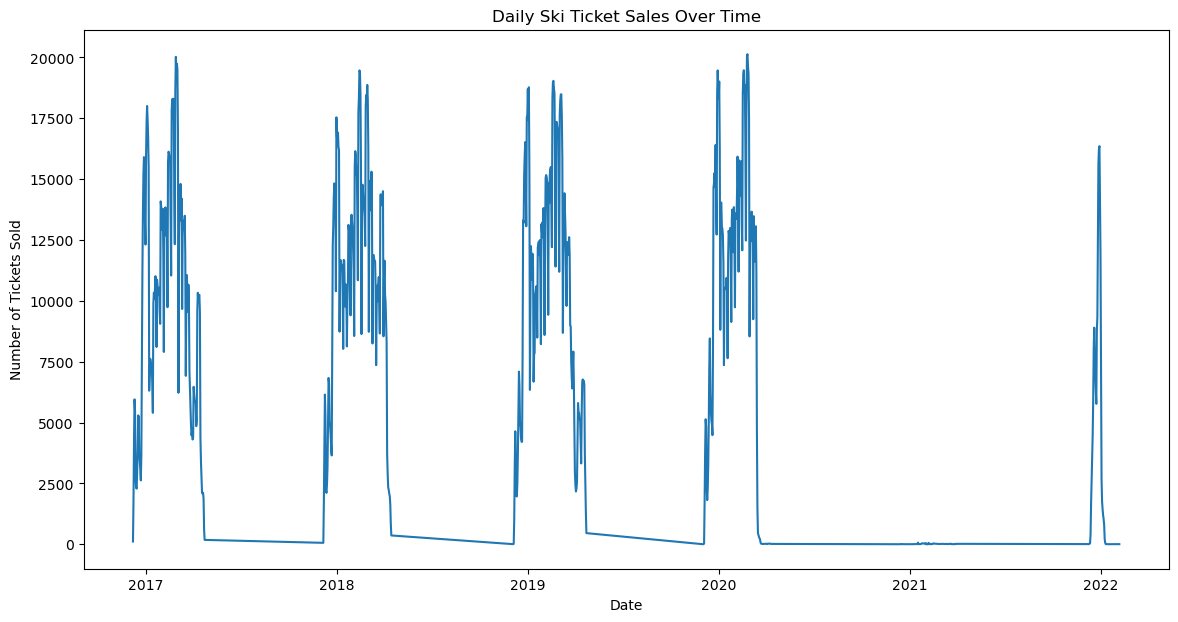

In [8]:
# Plot the time series of ticket sales
plt.figure(figsize=(14, 7))
plt.plot(df['Ski Day'], df['valid_tickets'], label='Valid Tickets')
plt.title('Daily Ski Ticket Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tickets Sold')
plt.show()

In [9]:
data = df.copy()
data

,Ski Day,valid_tickets
0,2016-12-07,112
1,2016-12-08,1769
2,2016-12-09,4230
3,2016-12-10,5952
4,2016-12-11,5451
...,...,...
678,2022-02-01,4
679,2022-02-02,4
680,2022-02-03,4
681,2022-02-04,4


In [10]:
data.set_index('Ski Day', inplace=True)
data['Year'] = data.index.year
data['Month'] = data.index.month


In [11]:
data

,valid_tickets,Year,Month
Ski Day,,,
2016-12-07,112,2016,12
2016-12-08,1769,2016,12
2016-12-09,4230,2016,12
2016-12-10,5952,2016,12
2016-12-11,5451,2016,12
...,...,...,...
2022-02-01,4,2022,2
2022-02-02,4,2022,2
2022-02-03,4,2022,2


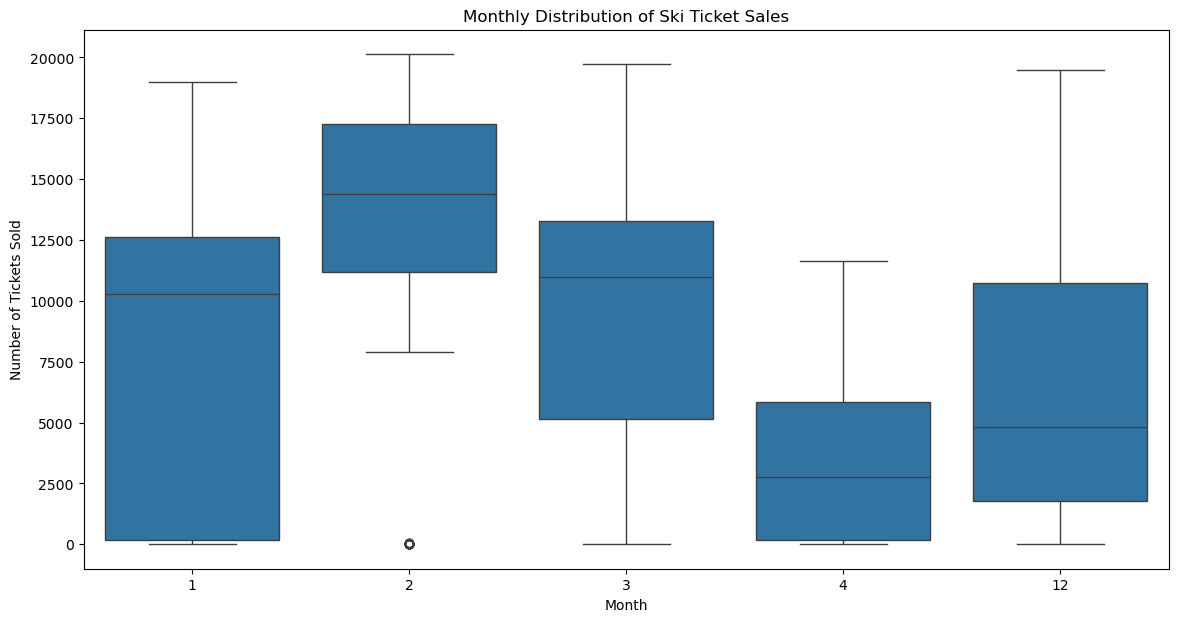

In [12]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Month', y='valid_tickets', data=data)
plt.title('Monthly Distribution of Ski Ticket Sales')
plt.xlabel('Month')
plt.ylabel('Number of Tickets Sold')
plt.show()

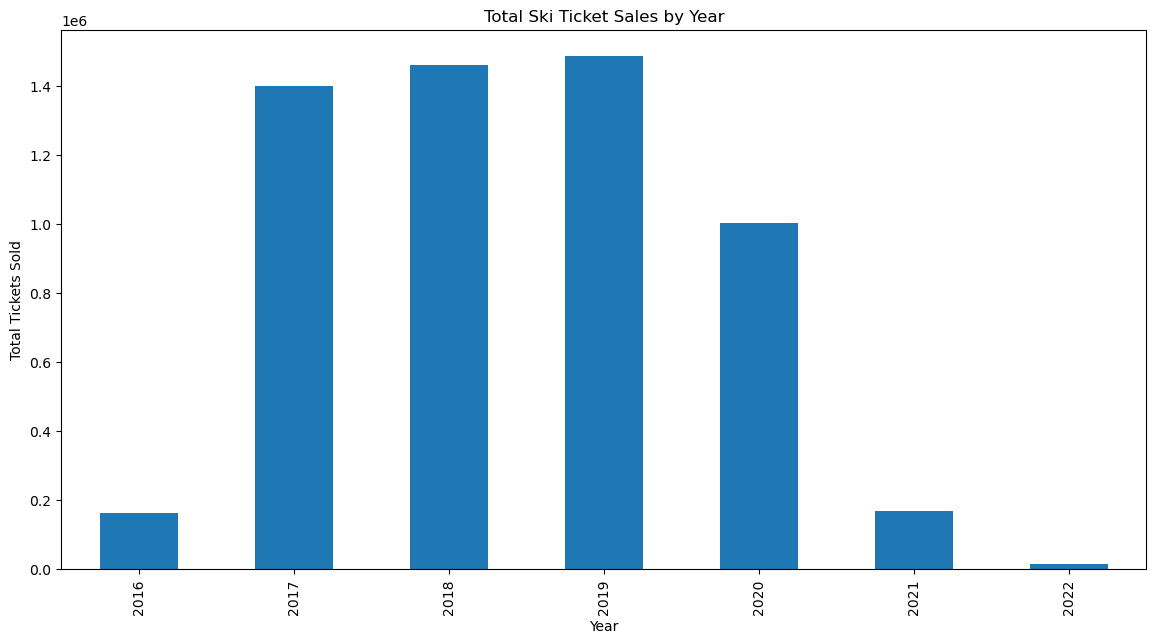

In [13]:
yearly_sales = data.groupby('Year')['valid_tickets'].sum()
plt.figure(figsize=(14, 7))
yearly_sales.plot(kind='bar')
plt.title('Total Ski Ticket Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Tickets Sold')
plt.show()

In [14]:
Q1 = df['valid_tickets'].quantile(0.25)
Q3 = df['valid_tickets'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['valid_tickets'] < (Q1 - 1.5 * IQR)) | (df['valid_tickets'] > (Q3 + 1.5 * IQR))]
outliers


,Ski Day,valid_tickets


In [15]:
#!pip install pmdarima

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from prophet import Prophet
from pmdarima import auto_arima

In [17]:
data = df.rename(columns={'Ski Day': 'ds', 'valid_tickets': 'y'})

In [18]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return mae, rmse

In [19]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [20]:
prophet_model = Prophet()
prophet_model.fit(train)
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_forecast = prophet_model.predict(future)
prophet_preds = prophet_forecast['yhat'][-len(test):]

14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:15 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
prophet_mae, prophet_rmse = evaluate_model(test['y'], prophet_preds, "Prophet")

Prophet - MAE: 83318.69, RMSE: 101081.75


In [22]:
arima_model = auto_arima(train['y'], seasonal=True, m=12, suppress_warnings=True)
arima_model.fit(train['y'])
arima_preds = arima_model.predict(n_periods=len(test))

In [23]:
arima_mae, arima_rmse = evaluate_model(test['y'], arima_preds, "ARIMA")

ARIMA - MAE: 9495.81, RMSE: 10021.55


In [24]:
results = {
    'Model': ['Prophet', 'ARIMA'],
    'MAE': [prophet_mae, arima_mae],
    'RMSE': [prophet_rmse, arima_rmse]
}
results_df = pd.DataFrame(results)
print(results_df)

     Model           MAE           RMSE
0  Prophet  83318.687020  101081.746747
1    ARIMA   9495.811115   10021.547345


In [25]:
test['y']

0      15
1      13
2       2
3       2
4       1
       ..
132     4
133     4
134     4
135     4
136     4
Name: y, Length: 137, dtype: int32

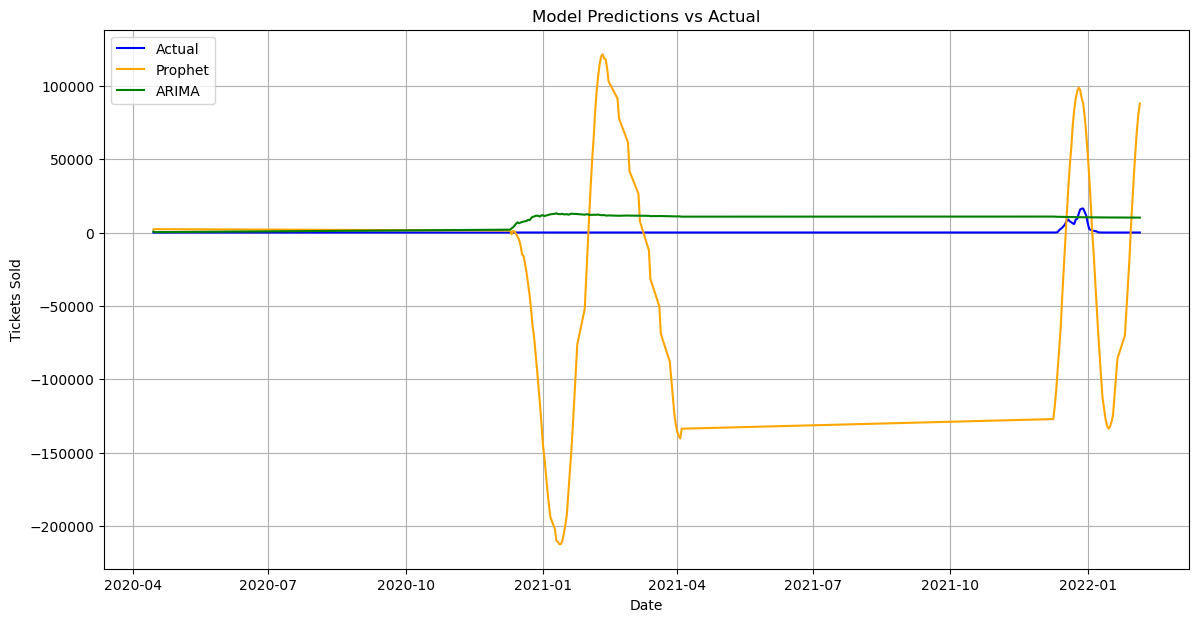

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(test['ds'], prophet_preds, label='Prophet', color='orange')
plt.plot(test['ds'], arima_preds, label='ARIMA', color='green')
plt.title('Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Tickets Sold')
plt.legend()
plt.grid(True)
plt.show()

14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mfliss\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\mfliss\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


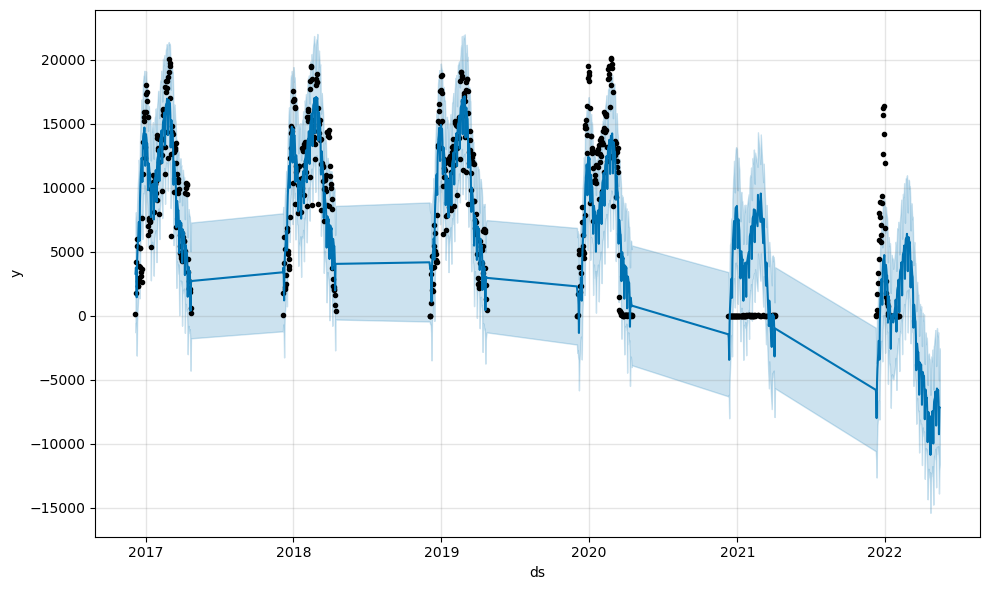

In [27]:
data2 = df.rename(columns={'Ski Day': 'ds', 'valid_tickets': 'y'})
prophet_model2 = Prophet()
prophet_model2.fit(data2)
future = prophet_model2.make_future_dataframe(periods=100)
prophet_forecast = prophet_model2.predict(future)
prophet_model2.plot(prophet_forecast)
plt.show()

In [28]:
future_dates = pd.date_range(start='2022-12-10', end='2023-04-15', freq='D')
future = pd.DataFrame({'ds': future_dates})

In [29]:
forecast = prophet_model2.predict(future)

In [30]:
forecasted_sales = forecast[['ds', 'yhat']]
forecasted_sales = forecasted_sales.rename(columns={'ds': 'Ski Day', 'yhat': 'Predicted Tickets'})

In [31]:
forecasted_sales.to_csv('fc2022_2023.csv', index=False)